# CuratorAI: A Personalized Art & Museum Discovery Engine
***Building an AI-Powered Museum Guide***

# Table of Contents
1. [Overview 🎯](##overview)
2. [Data Import 📥](##data-import)
3. [Pre-Processing 🧹](##pre-processing)
4. [Exploratory Data Analysis 🔍](##exploratory-data-analysis)
5. [Feature Engineering ⚙️](##feature-engineering)
6. [Model Building & Training 🤖](##model-building--training)
7. [Model Evaluation & Validation 📊](##model-evaluation--validation)
8. [Model Deployment 💾](##model-deployment)
9. [Conclusion & Next Steps 📝](##conclusion--next-steps)


## Overview

**The Art Discovery Problem**

> **"I know what I like, but I don't know how to find more of it."**

This simple frustration echoes through the grand halls of museums worldwide. Visitors stand before masterpieces feeling overwhelmed by choice, unsure where to turn next in collections spanning 5,000 years of human creativity. The Metropolitan Museum of Art alone houses over 470,000 artworks—enough to spend 30 seconds on each piece for 163 consecutive days.


**The Business Challenge**

Museums face a critical engagement problem:
- <u>Visitor Overwhelm</u>: Too many choices lead to decision paralysis
- <u>Personalization Gap</u>: One-size-fits-all audio guides and maps
- <u>Discovery Barriers</u>: Visitors struggle to find artworks that resonate with their personal tastes
- <u>Digital Engagement</u>: Online collections remain underutilized without intelligent navigation


**Solution: CuratorAI**

CuratorAI is an intelligent recommendation system that transforms art discovery from being overwhelming to personalized. By analyzing the textual artworks, their titles, artists, cultural contexts, and historical periods, building bridges between what you love and what you'll love next.

Think of it as: 
> **"The Netflix for art, the Spotify for sculptures, the personal curator in your pocket."**


**Technical Approach**
- <u>Content-Based Filtering</u>: Using TF-IDF and Nearest Neighbors to find similar artworks
- <u>Feature Engineering</u>: Transforming textual metadata into meaningful numerical representations
- <u>End-to-End Pipeline</u>: From raw data to deployed web application
- <u>Real-World Constraints</u>: Working within The Met's Open Access data policies


**Value Proposition**

For **art lovers**: Discover hidden gems and personal connections across centuries
For **museums**: Increase engagement, visit duration, and digital interaction
For **educators**: Create thematic learning journeys through visual culture

**Let's begin our journey through data, art, and machine learning—transforming how the world discovers beauty.**

## Data Import

In [1]:
# Data & ML
import pandas as pd
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import joblib

# API & Images
import requests
import json
from PIL import Image
from io import BytesIO
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading dataset
df = pd.read_csv('/Users/Rosella/Downloads/Personal-Projects/Production-ML-Portafolio/CuratorAI/MetObjects.csv')

# General info
df.info()

# Data columns
print(f'\nRows and columns: {df.shape}')

# First 10 rows
print("\nFirst 10 rows with all columns:")
print(df.head(10).to_string())

# Systematic assesment
missing_analysis = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_analysis / len(df) * 100)

print("\nColumns missing values:")
print(missing_percentage)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Object Number            484956 non-null  object 
 1   Is Highlight             484956 non-null  bool   
 2   Is Timeline Work         484956 non-null  bool   
 3   Is Public Domain         484956 non-null  bool   
 4   Object ID                484956 non-null  int64  
 5   Gallery Number           49541 non-null   object 
 6   Department               484956 non-null  object 
 7   AccessionYear            481094 non-null  object 
 8   Object Name              482690 non-null  object 
 9   Title                    456153 non-null  object 
 10  Culture                  208190 non-null  object 
 11  Period                   91143 non-null   object 
 12  Dynasty                  23201 non-null   object 
 13  Reign                    11236 non-null   object 
 14  Port

The initial exploration reveals several data quality challenges that require systematic addressing:

**Data Quality Issues Identified:**
- **Missing Values**: Critical fields like `Artist Display Name` (59% missing), `Object Date` (97.2% missing), `Culture` (43% missing), require strategic handling.
- **Data Type Mismatches**: Numeric fields stored as objects, date information inconsistently formatted
- **Column Relevance**: Only ~15 of 45 columns directly support the recommendation objective
- **Data Integrity**: Need to verify no duplicate `Object ID` entries and validate image URL availability

**Immediate Action Plan:**
1. Identify the optimal subset of columns for feature engineering and check thier missing values percentaje
2. Develop a missing data strategy (imputation vs. filtering)
3. Validate data types and convert if necessary

## Pre-Processing

In [3]:
# Optimal columns
primary_columns = ['Object ID',
                    'Title', 
                    'Object Name',
                    'Object Begin Date',
                    'Object End Date',
                    'Department', 
                    'Classification',
                    'Medium'
                    ]

image_columns = ['Link Resource',
                  'Dimensions'
                  ]

# Checking missing values percentaje
def checking_nulls(columns):
    for col in columns:
        complete_percentage = (1 - df[col].isnull().mean()) * 100

        print(f'{col}: {complete_percentage}')

checking_nulls(primary_columns)
print()
checking_nulls(image_columns)

# Creating new dataset with select columns
selected_columns = primary_columns + image_columns
data = df[selected_columns].copy()

# Cheking data types for the new dataset
print('\nData Types:')
print(data.dtypes)

# Cheking null values
print('\nNull values before cleaning:')
for col in selected_columns:
    if data[col].isnull().sum() > 0:
        print(f'Column {col}: {data[col].isnull().sum()}')

# Handeling null values
data['Title'].fillna('Untitled', inplace=True)
data['Object Name'].fillna('Artwork', inplace=True)
data['Classification'].fillna('Unclassified', inplace=True)
data['Medium'].fillna('Medium unknown', inplace=True)
data['Dimensions'].fillna('Dimensions unavailable', inplace=True)
print(f'\nNull values after cleaning: {data.isnull().sum().sum()}')

# Checking for duplicates
if data.duplicated().sum() > 0:
    print('⚠️  Duplicates found - investigate before proceeding')
else:
    print('✅ No duplicate records')

# Clean Dataset
print('\n=== CLEAN DATASET READY ===')
print(f'Final shape: {data.shape}')
data.head()


Object ID: 100.0
Title: 94.06069829015415
Object Name: 99.53274111465782
Object Begin Date: 100.0
Object End Date: 100.0
Department: 100.0
Classification: 83.76821814762576
Medium: 98.51223616163117

Link Resource: 100.0
Dimensions: 84.5227195869316

Data Types:
Object ID             int64
Title                object
Object Name          object
Object Begin Date     int64
Object End Date       int64
Department           object
Classification       object
Medium               object
Link Resource        object
Dimensions           object
dtype: object

Null values before cleaning:
Column Title: 28803
Column Object Name: 2266
Column Classification: 78717
Column Medium: 7215
Column Dimensions: 75058

Null values after cleaning: 0
✅ No duplicate records

=== CLEAN DATASET READY ===
Final shape: (484956, 10)


,Object ID,Title,Object Name,Object Begin Date,Object End Date,Department,Classification,Medium,Link Resource,Dimensions
0,1,One-dollar Liberty Head Coin,Coin,1853,1853,The American Wing,Unclassified,Gold,http://www.metmuseum.org/art/collection/search/1,Dimensions unavailable
1,2,Ten-dollar Liberty Head Coin,Coin,1901,1901,The American Wing,Unclassified,Gold,http://www.metmuseum.org/art/collection/search/2,Dimensions unavailable
2,3,Two-and-a-Half Dollar Coin,Coin,1909,1927,The American Wing,Unclassified,Gold,http://www.metmuseum.org/art/collection/search/3,Diam. 11/16 in. (1.7 cm)
3,4,Two-and-a-Half Dollar Coin,Coin,1909,1927,The American Wing,Unclassified,Gold,http://www.metmuseum.org/art/collection/search/4,Diam. 11/16 in. (1.7 cm)
4,5,Two-and-a-Half Dollar Coin,Coin,1909,1927,The American Wing,Unclassified,Gold,http://www.metmuseum.org/art/collection/search/5,Diam. 11/16 in. (1.7 cm)



Data preprocessing prepared 10 core columns for analysis:
- **Feature Selection**: 10 columns with >83% completeness covering artwork identity, context, and visual resources
- **Data Types**: Dates kept as integers for easier era analysis and segmentation  
- **Missing Values**: Strategic placeholders ("Unknown", "Unclassified") for categorical columns
- **Data Integrity**: No duplicate records found

Ready for Exploratory Data Analysis to uncover patterns in artwork distribution, historical trends, and categorical relationships.

## Exploratory Data Analysis

=== CATEGORICAL DISTRIBUTION ANALYSIS ===


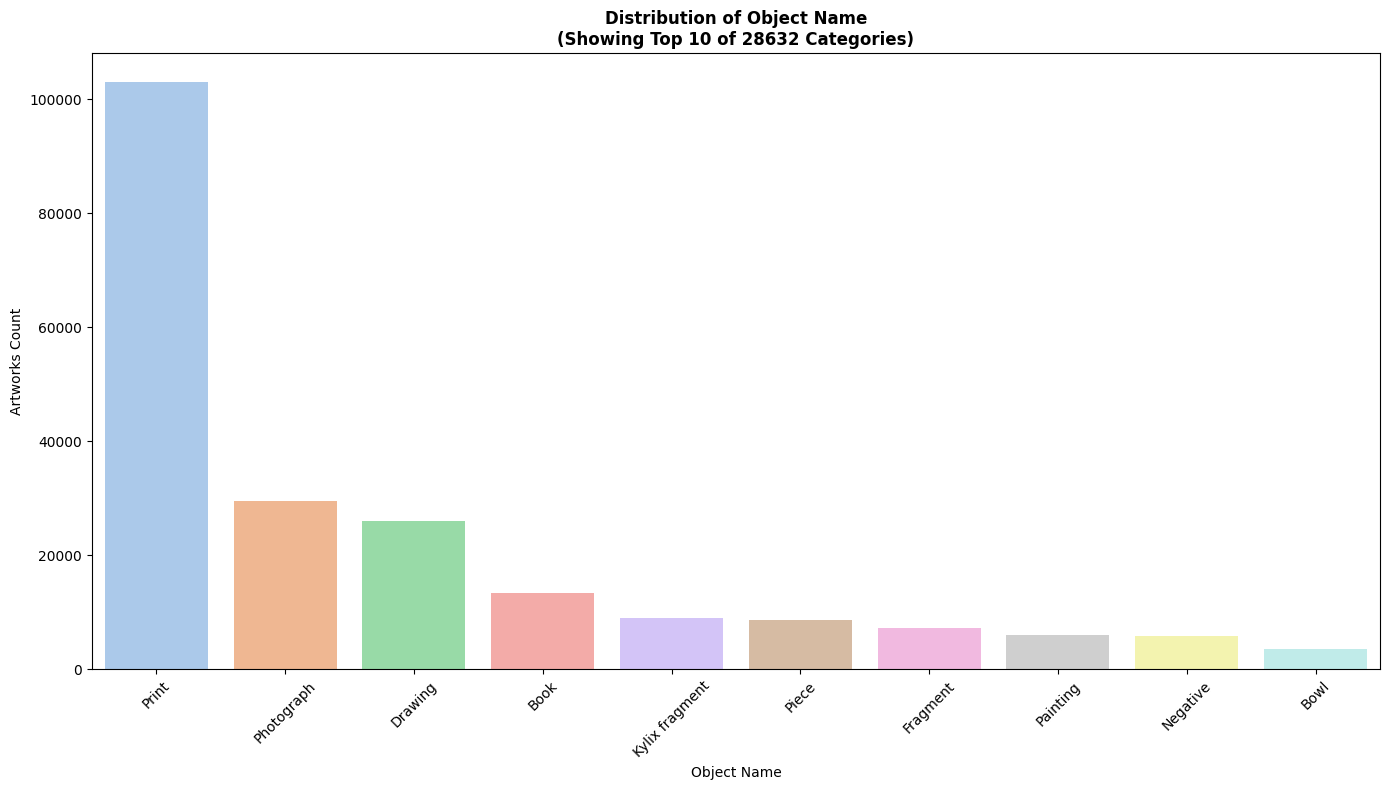

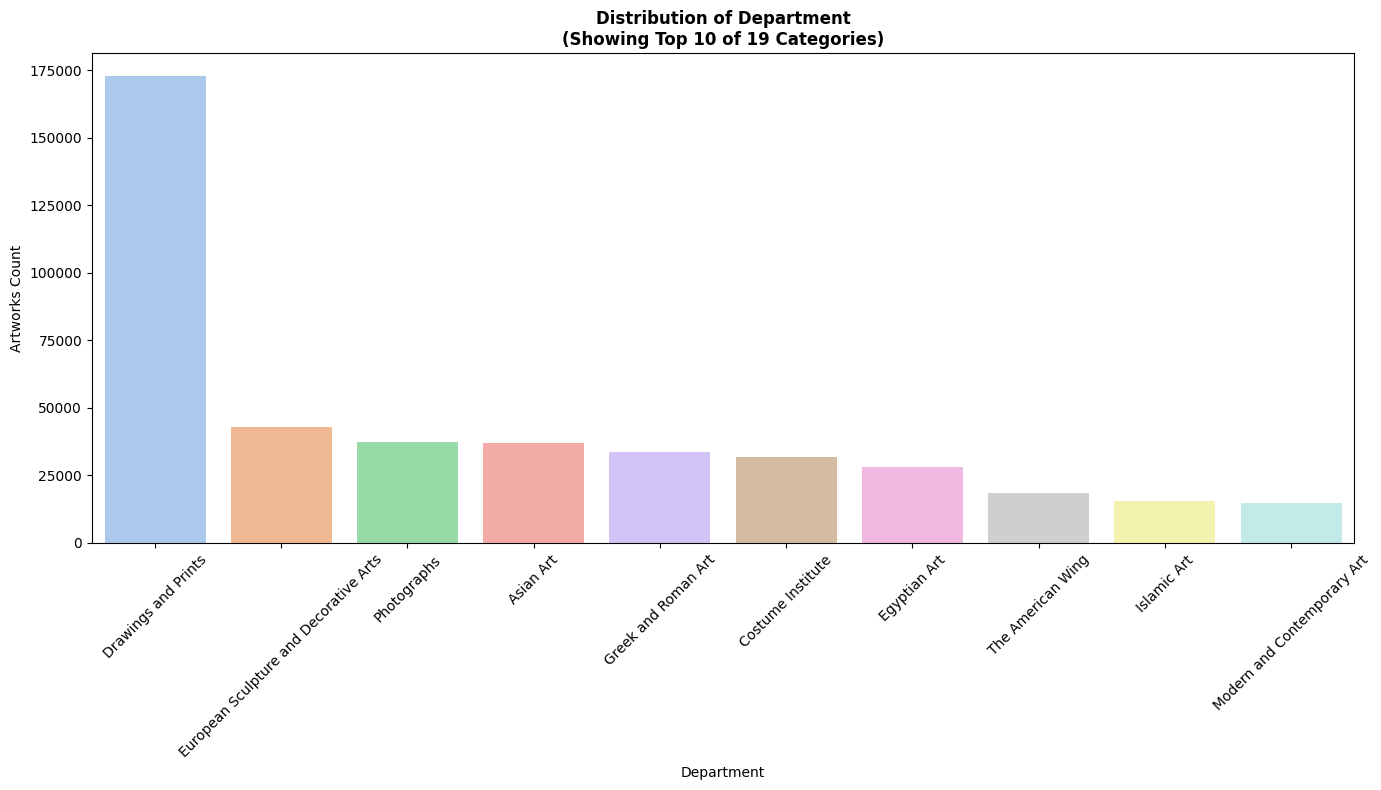

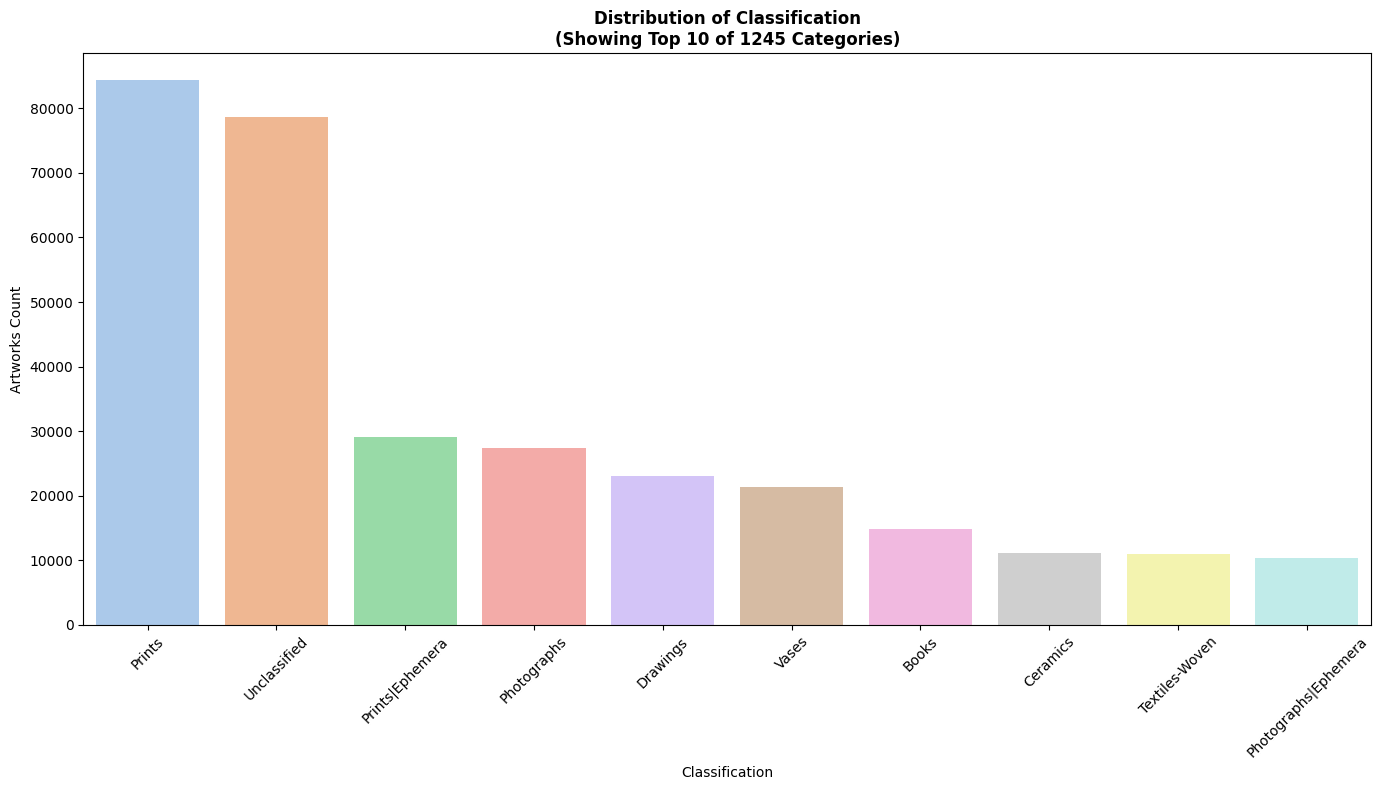

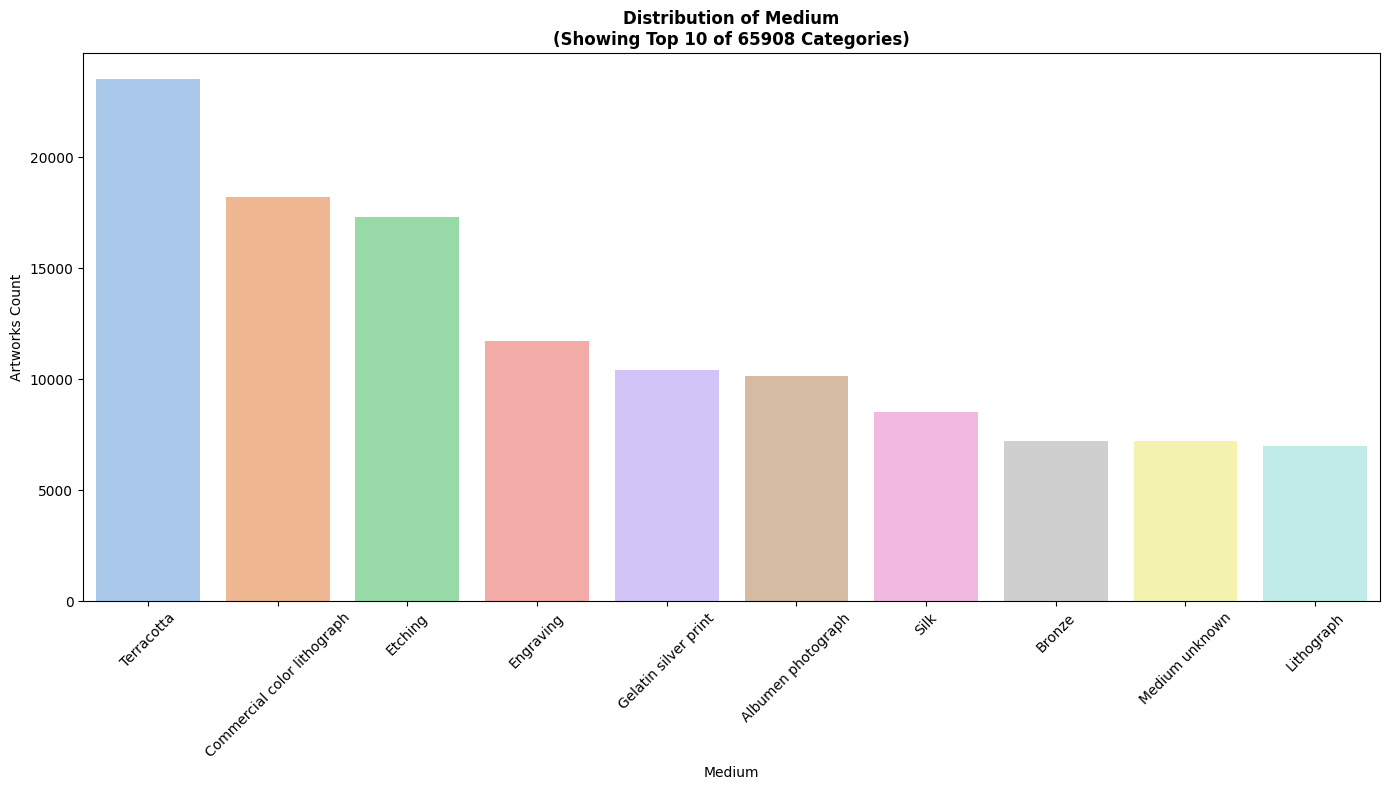

In [4]:
# Categorical columns exploration
print("=== CATEGORICAL DISTRIBUTION ANALYSIS ===")
categorical_columns = ['Object Name', 'Department', 'Classification', 'Medium']


for col in categorical_columns:
    # Top categories
    cat_value_counts = data[col].value_counts().head(10)
    plt.figure(figsize=(14, 8))
    bar1 = sns.barplot(x=cat_value_counts.index, y=cat_value_counts.values, palette='pastel')
    plt.title(f'Distribution of {col}\n(Showing Top 10 of {data[col].nunique()} Categories)', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Artworks Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

=== DEPARTMENT DIVERSITY ===


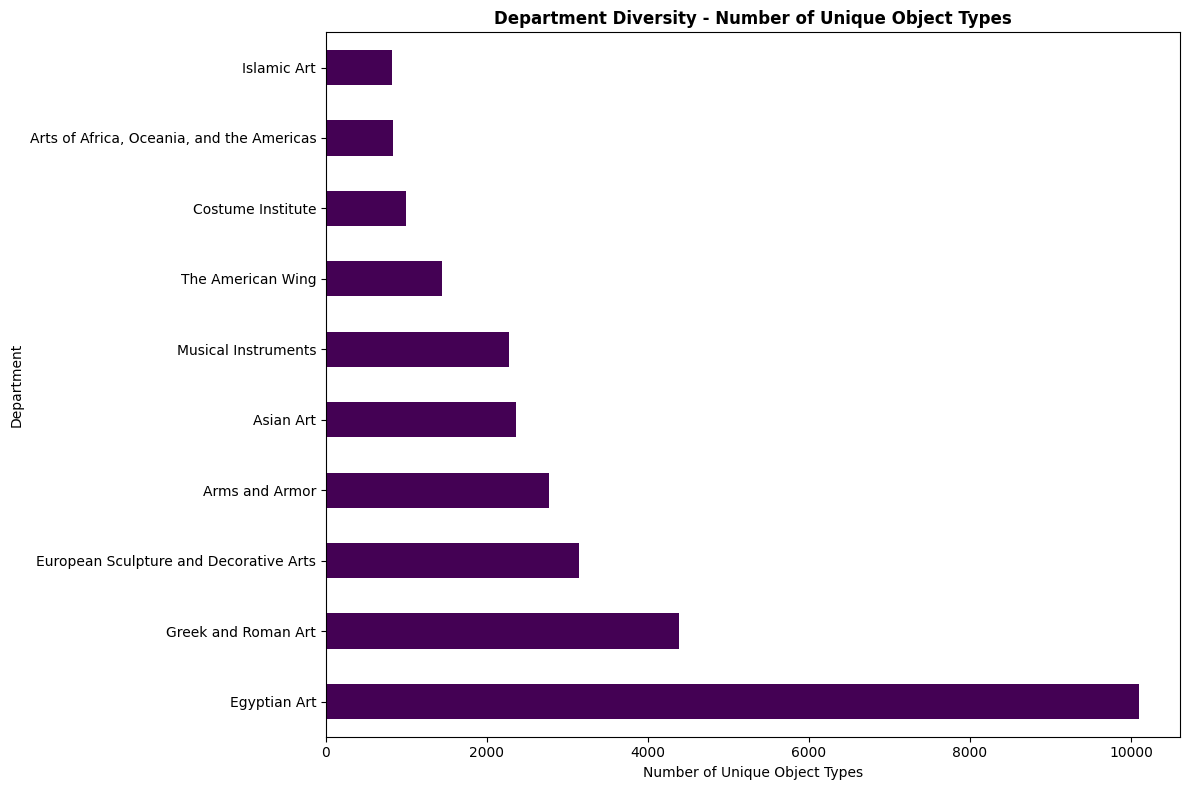

In [5]:
# Deparments with most diverse collections
print("=== DEPARTMENT DIVERSITY ===")
dept_diversity = data.groupby('Department')['Object Name'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
dept_diversity.plot(kind='barh', colormap='viridis')
plt.title('Department Diversity - Number of Unique Object Types', fontweight='bold')
plt.xlabel('Number of Unique Object Types')
plt.tight_layout()
plt.show()



== ARTWORK BY HISTORICAL ERA ==
Artwork Era
19th Centuary                   135646
Renaissance to Enlightenment    128103
20th Centuary                   109858
Classical                        46019
Medival                          30367
Ancient - Bronze Age             24875
Ancient - Iron Age                4863
Modern/Contemporary               3151
Prehistoric                       2074
Name: count, dtype: int64

=== EVOLUTION OF ARTISTIC MATERIALS OVER TIME ===


<Figure size 1400x1200 with 0 Axes>

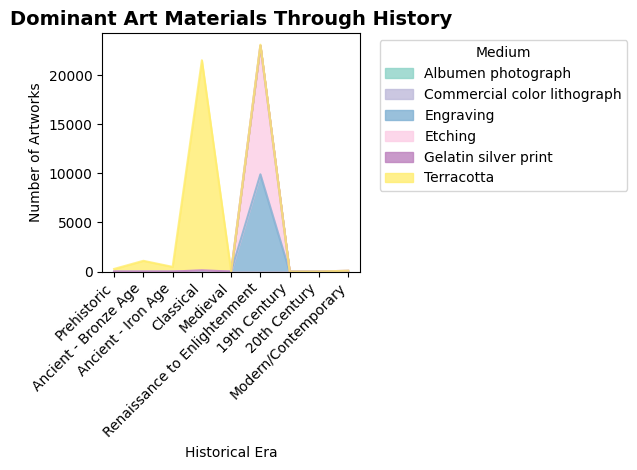

In [6]:
# Artworks by eras
def categorized_by_centuary(begin_date):
    if begin_date < -4000:
        return 'Prehistoric'
    elif -4000 <= begin_date < -1200:
        return 'Ancient - Bronze Age'
    elif -800 <= begin_date < 500:
        return 'Classical'
    elif 500 <= begin_date < 1500:
        return 'Medival'
    elif 1500 <= begin_date < 1800:
        return 'Renaissance to Enlightenment'
    elif 1800 <= begin_date < 1900:
        return '19th Centuary'
    elif 1900 <= begin_date < 2000:
        return '20th Centuary'
    elif begin_date >= 2000:
        return 'Modern/Contemporary'
    else:
        return 'Ancient - Iron Age'

data['Artwork Era'] = data['Object Begin Date'].apply(categorized_by_centuary)
col = data.pop('Artwork Era')
data.insert(5, 'Artwork Era', col)
print('\n== ARTWORK BY HISTORICAL ERA ==') 
print(data['Artwork Era'].value_counts())

# Evolution of mediums by eras
print("\n=== EVOLUTION OF ARTISTIC MATERIALS OVER TIME ===")
top_6_mediums = data['Medium'].value_counts().head(6).index
evolution_data = data[data['Medium'].isin(top_6_mediums)]

# Create timeline data
timeline = evolution_data.groupby(['Artwork Era', 'Medium']).size().unstack(fill_value=0)
era_order = ['Prehistoric', 'Ancient - Bronze Age', 'Ancient - Iron Age', 'Classical', 'Medieval', 'Renaissance to Enlightenment', '19th Century', '20th Century', 'Modern/Contemporary']
timeline = timeline.reindex(era_order)

plt.figure(figsize=(14, 12))
timeline.plot(kind='area', stacked=True, colormap='Set3', alpha=0.8)
plt.title('Dominant Art Materials Through History', fontweight='bold', fontsize=14)
plt.xlabel('Historical Era')
plt.ylabel('Number of Artworks')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Medium', frameon=True)
plt.xticks(range(len(era_order)), era_order, rotation=45, ha='right') 
plt.tight_layout()
plt.subplots_adjust()
plt.show()

The analysis reveals a collection dominated by European historical art, with the 19th Century and Renaissance periods collectively comprising over 260,000 artworks. The Drawing, Prints, and Photographs departments emerge as the most substantial collections by volume.

Department diversity analysis indicates Islamic Art leads in categorical variety, with over 10,000 unique object types demonstrating exceptional cultural breadth. The Arts of Africa, Oceania, and the Americas also show significant material diversity within their respective collections.

Analysis of artistic materials across historical eras shows a distinct technological progression from traditional printmaking and drawing techniques to modern photographic processes, with albumen prints and gelatin silver prints becoming predominant in the 19th and 20th centuries.

These findings inform the recommendation strategy: leverage the extensive photographic and print collections for broad coverage, utilize the diverse Islamic and Asian art objects for culturally rich suggestions, and strategically surface underrepresented Modern/Contemporary works (3,151 artworks) to provide balanced discovery opportunities.

## Feature Engineering

This phase transforms raw categorical data into machine-readable features and establishes the visual component critical for the recommendation experience.

**Visual Content Integration**
A dedicated image extraction pipeline leverages the Met Museum Object API, using each artwork's `Object ID` to retrieve high-quality images via HTTP requests. This ensures the recommendation system displays actual artwork visuals rather than textual descriptions, creating an engaging user experience.

Once objects with available images are identified, the dataset is filtered to include only artworks with confirmed images and selected feature columns. This curated subset ensures both visual integrity and data quality for model training.

**Categorical Feature Engineering**
With the final visual dataset established, categorical columns (`Title`, `Object Name`, `Artwork Era`, `Department`, `Classification`, `Medium`) are processed using TF-IDF vectorization to create semantic feature vectors. This approach captures thematic relationships between artworks based on their descriptive metadata, enabling content-based similarity matching.

In [7]:
# Visual Content Integration
# Defined function for image extraction
def get_artwork_images(object_id):
    try:
        url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{object_id}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            # Checks primary image exists
            if data.get('primaryImage'):
                return {
                    'primaryImage': data['primaryImage'],
                    'primaryImageSmall': data.get('primaryImageSmall', ''),
                    'additionalImages': data.get('additionalImages', [])
                }
        return None
    except:
        return None

# Testing to make sure images are function works
print('== TESTING IMAGE EXTRACTION FUNCTION ==')
print(f"Object ID {10}: {'Has images' if (get_artwork_images(10)) else 'No images'}")
print(f"Object ID {100}: {'Has images' if (get_artwork_images(100)) else 'No images'}")
print(f"Object ID {200}: {'Has images' if (get_artwork_images(200)) else 'No images'}")

# Sample a subset of dataset to test image availability
print('\n== CHECKING IMAGE AVAILABILITY FOR A SAMPLE ==')
def image_availability(sample_size=1000):
    sample_data = data.head(sample_size).copy(True)
    has_images = 0

    print(f"Checking image availability for {sample_size} artworks...")
    for idx, row in sample_data.iterrows():
        images = get_artwork_images(row['Object ID'])
        if images:
            has_images += 1
        time.sleep(0.1)
    
    coverage = (has_images / sample_size) * 100
    print(f"✅ Image coverage: {coverage:.1f}% ({has_images}/{sample_size})")
    return coverage
coverage_rate = image_availability(500)  # 500 for speed


== TESTING IMAGE EXTRACTION FUNCTION ==
Object ID 10: No images
Object ID 100: Has images
Object ID 200: Has images

== CHECKING IMAGE AVAILABILITY FOR A SAMPLE ==
Checking image availability for 500 artworks...
✅ Image coverage: 24.2% (121/500)


In [8]:
# Calculating estimate images for the whole dataset
total_artworks = len(data)
estimated_with_images = total_artworks * 0.286  # 28.6% coverage
print(f"Estimated artworks with images: {estimated_with_images:,.0f}")

if estimated_with_images > 20000:
    print("✅ Still have plenty of artworks - proceed with filtering!")
else:
    print("🔄 Use curated approach for guaranteed quality")

Estimated artworks with images: 138,697
✅ Still have plenty of artworks - proceed with filtering!


In [ ]:
# Filtering dataset
final_data_list = []
sample_size = 150000

for idx, row in data.head(sample_size).iterrows():
    images = get_artwork_images(row['Object ID'])

    if images:
        row_data = row.to_dict()
        row_data.update(images)
        final_data_list.append(row_data)

final_data = pd.DataFrame(final_data_list)
print(f"Found {len(final_data)} artworks with images")

In [ ]:
# Categorical Feature Engineering
# Combine categorical columns in one feature
final_data['Combined Features'] = (
    final_data['Title'] + " | " +
    final_data['Object Name'] + " | " +
    final_data['Artwork Era'] + " | " +
    final_data['Department'] + " | " + 
    final_data['Classification'] + " | " +
    final_data['Medium']
)

# Example of the new combined features
print('== COMBINED FEATURES ==')
print(f'Sample of combined features:\n{final_data['Combined Features'].iloc[0]}')

# Initialize and fit the vectorizer
vectorizer = TfidfVectorizer(
    max_features=30000,
    stop_words='english',
    ngram_range=(1, 2)
)
tfidf_matrix = vectorizer.fit_transform(final_data['Combined Features'])

print("\n=== OPTIMIZED TF-IDF ===")
print(f"Feature matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
